# importing packgae

In [1042]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, confusion_matrix
from sklearn.metrics import precision_recall_curve, roc_auc_score, roc_curve, log_loss, auc
from sklearn.feature_selection import RFE

%matplotlib inline

#setting the figure size
plt.rcParams['figure.figsize'] = [10, 10]

## load dataset

In [832]:
# loading the titanic dataset

titanic =  sns.load_dataset('titanic')

# printing the first 5 row of the dataset
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [833]:
# print detail about dataset

titanic.describe()

,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [834]:
# checking the number of row and columns

titanic.shape

(891, 15)

# Data exploration

## checking missing values

In [835]:
titanic.isna().sum()

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

## ploting heatmap

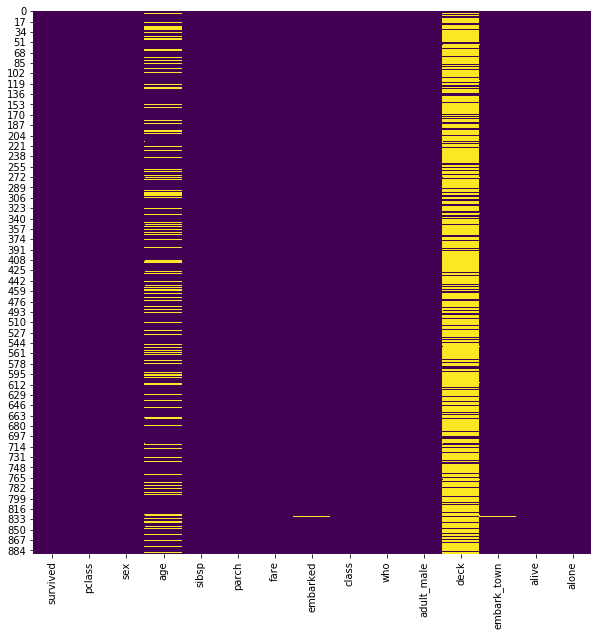

In [836]:
# visualize the missing values in the dataset

sns.heatmap(titanic.isnull(), cbar=False, cmap='viridis')

In [837]:
# check the percent of missing values in age column

titanic['age'].isnull().sum() * 100 / titanic.shape[0]

19.865319865319865

In [838]:
# check the percent of missing values in deck columns

titanic['deck'].isnull().sum() * 100 / titanic.shape[0]

77.21661054994388

## distribution of age

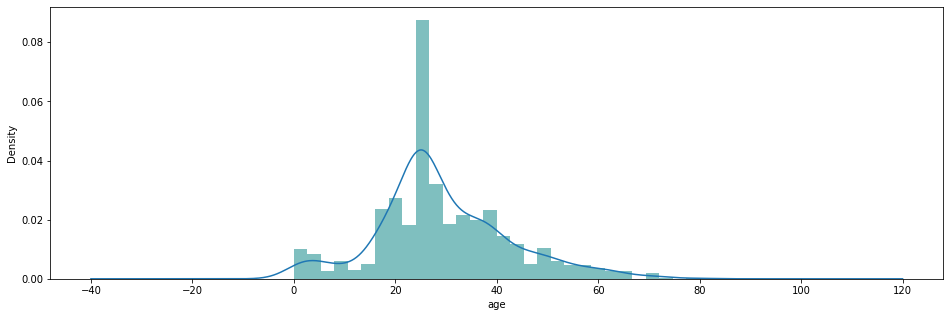

In [1059]:
# plot the distribution of age

ax = titanic['age'].hist(bins = 30, density = True, stacked = True, color = 'teal', alpha = 0.5, figsize= (16,5))
titanic['age'].plot(kind = 'density')
ax.set_xlabel('age')
plt.show()

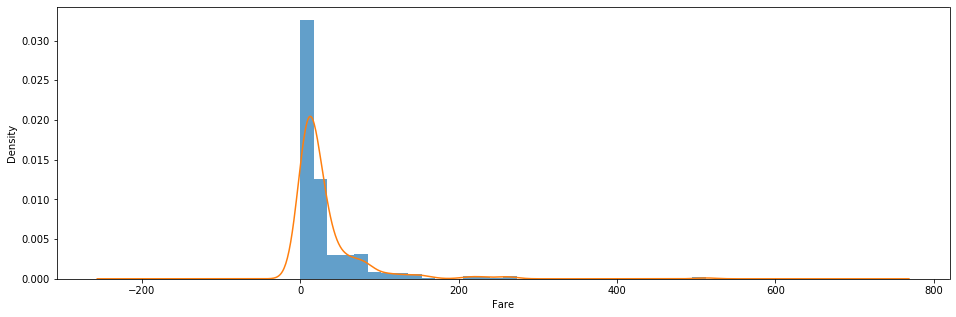

In [840]:
# plot the distribution of fare

ax = titanic['fare'].hist(bins = 30, density = True, stacked = True, alpha = 0.7, figsize = (16, 5))
titanic['fare'].plot(kind = 'density')
ax.set_xlabel('Fare')
plt.show()

Text(0.5, 1.0, 'Male')

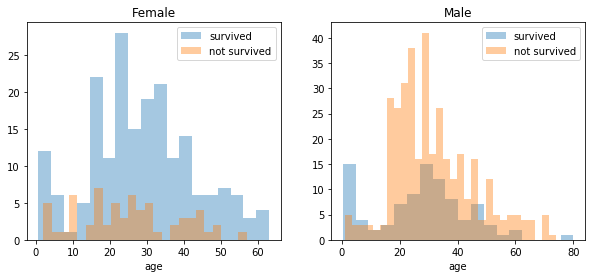

In [841]:
# distribution of survived people according to there age
# what is the factor of the age in surviving of the people

survived = 'survived'
not_survived = 'not survived'

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))

women = titanic[titanic['sex'] == 'female']
men = titanic[titanic['sex'] == 'male']

ax = sns.distplot(women[women[survived] == 1]['age'].dropna(), bins = 18, label = survived, ax = axes[0], kde = False)
ax = sns.distplot(women[women[survived] == 0]['age'].dropna(), bins = 24, label = not_survived, ax = axes[0], kde = False)
ax.legend()
ax.set_title('Female')


ax = sns.distplot(men[men[survived] == 1]['age'].dropna(), bins = 18, label = survived, ax = axes[1], kde = False)
ax = sns.distplot(men[men[survived] == 0]['age'].dropna(), bins = 30, label = not_survived, ax = axes[1], kde = False)
ax.legend()
ax.set_title('Male')

In [842]:
# count the number of male and female

titanic['sex'].value_counts(normalize=True)

# we can see that there are 64% male and 35% female

male      0.647587
female    0.352413
Name: sex, dtype: float64

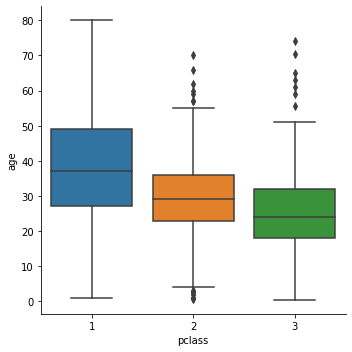

In [843]:
# let's see the relation between the passanger class and the age

sns.catplot(x = 'pclass', y = 'age', kind = 'box', data = titanic)

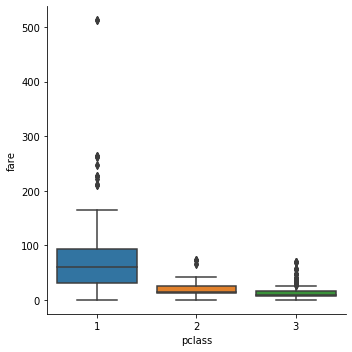

In [844]:
# let's see the relationsship between pclass and fare

sns.catplot(x = 'pclass', y = 'fare', kind = 'box', data = titanic)

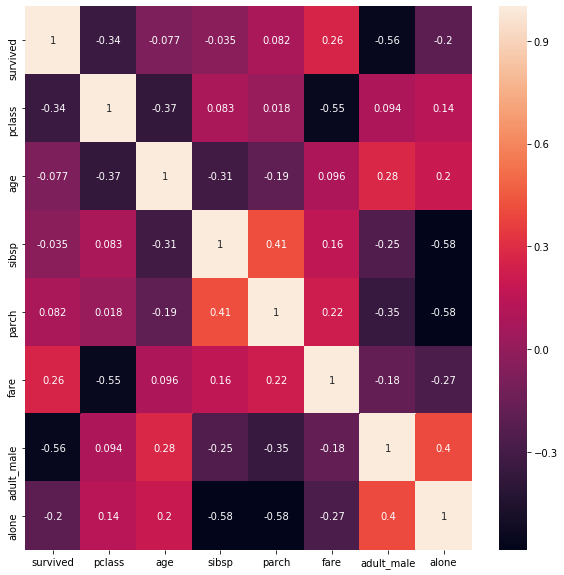

In [845]:
# visualize the corellation between variables

sns.heatmap(titanic.corr(), annot=True)

In [846]:
# find the mean of those passenger who are in 1st class

print('Mean age of passenger in 1st class: ', titanic[titanic['pclass'] == 1]['age'].mean())
print('Mean age of passenger in 2nd class: ', titanic[titanic['pclass'] == 2]['age'].mean())
print('Mean age of passenger in 3rd class: ', titanic[titanic['pclass'] == 3]['age'].mean())

Mean age of passenger in 1st class:  38.233440860215055
Mean age of passenger in 2nd class:  29.87763005780347
Mean age of passenger in 3rd class:  25.14061971830986


## fill the missing value in age

In [847]:
# function to replace the missing value with mean of age

def missing_age(cols):
    age = cols[0]
    pclass = cols[1]
    
    
    if pd.isnull(age):
        if pclass == 1:
            return titanic[titanic['pclass'] == 1]['age'].mean()
        
        elif pclass == 2:
            return titanic[titanic['pclass'] == 2]['age'].mean()
        
        elif pclass == 3:
            return titanic[titanic['pclass'] == 3]['age'].mean()
    
    else:
        return age
    

In [848]:
titanic['age'] = titanic[['age', 'pclass']].apply(missing_age, axis = 1)

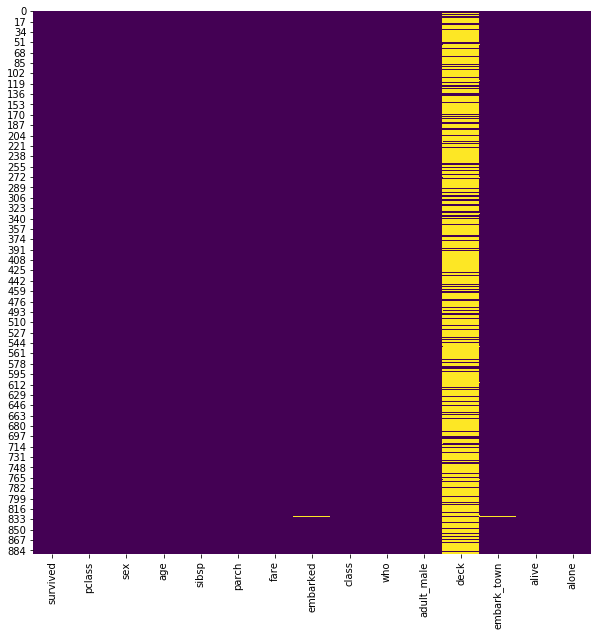

In [849]:
# plot to see if there is any missing vale in the age column

sns.heatmap(titanic.isnull(), cbar = False, cmap='viridis')

# Analysing column embarked 

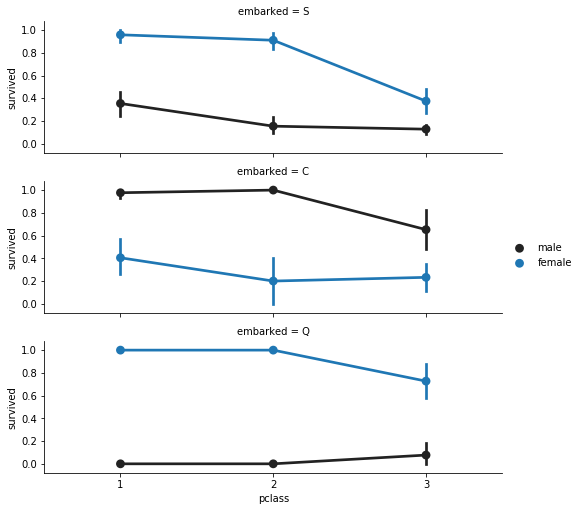

In [850]:
f = sns.FacetGrid(titanic, row = 'embarked', height=2.4, aspect=3)
f.map(sns.pointplot, 'pclass', 'survived', 'sex', order=None, hue_order = None)
f.add_legend()

In [851]:
# checking for missing value in embarked column

titanic['embarked'].isnull().sum()

2

In [852]:
# get the value count of embarked

titanic['embarked'].value_counts()

S    644
C    168
Q     77
Name: embarked, dtype: int64

In [853]:
# since most of the people borad the ship from 'S'  we will fill the missing valye with 'S'

titanic['embarked'].fillna('S', inplace=True)

In [854]:
# checking for missing value after filling the missing value

titanic['embarked'].isnull().sum()

0

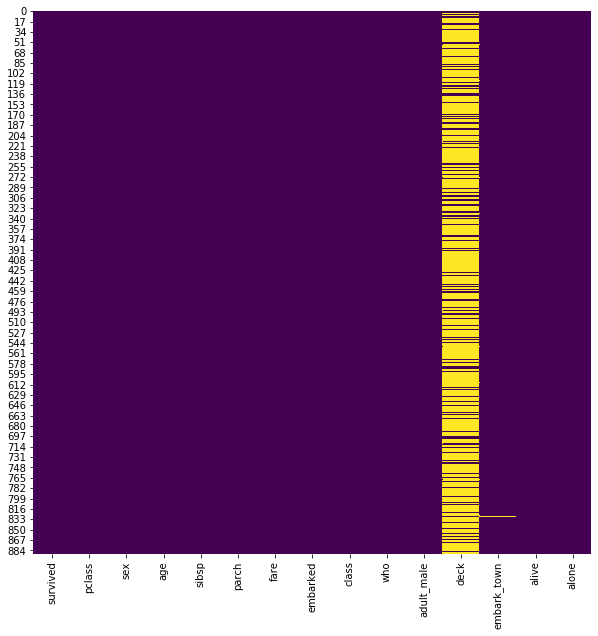

In [855]:
# let's re-confirm this with the heat map

sns.heatmap(titanic.isnull(), cbar = False, cmap='viridis')

## dropping columns

In [856]:
# we will be dropping three columns

titanic.drop(['deck', 'alive', 'embark_town', 'class'], axis=1, inplace=True)

In [857]:
titanic.head(2)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,who,adult_male,alone
0,0,3,male,22.0,1,0,7.2500,S,man,True,False
1,1,1,female,38.0,1,0,71.2833,C,woman,False,False


In [858]:
# checking the datatype and the memory usage

titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
survived      891 non-null int64
pclass        891 non-null int64
sex           891 non-null object
age           891 non-null float64
sibsp         891 non-null int64
parch         891 non-null int64
fare          891 non-null float64
embarked      891 non-null object
who           891 non-null object
adult_male    891 non-null bool
alone         891 non-null bool
dtypes: bool(2), float64(2), int64(4), object(3)
memory usage: 64.5+ KB


In [859]:
# since the datatype are not same , we will change the data type

titanic[['age', 'fare']] = titanic[['age', 'fare']].astype('int')

In [860]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
survived      891 non-null int64
pclass        891 non-null int64
sex           891 non-null object
age           891 non-null int64
sibsp         891 non-null int64
parch         891 non-null int64
fare          891 non-null int64
embarked      891 non-null object
who           891 non-null object
adult_male    891 non-null bool
alone         891 non-null bool
dtypes: bool(2), int64(6), object(3)
memory usage: 64.5+ KB


## convert categorical data into numerica data (Encoding)

In [861]:
# coverting sex column

label_encoder = LabelEncoder()

titanic['sex'] = label_encoder.fit_transform(titanic['sex'])
titanic['alone'] = label_encoder.fit_transform(titanic['alone'])
titanic['adult_male'] = label_encoder.fit_transform(titanic['adult_male'])

In [862]:
# coverting who, and embarked column

one_hot_encoding = OneHotEncoder()

who_encode = pd.get_dummies(titanic[['who', 'embarked']])

titanic = titanic.drop(['who', 'embarked'], axis=1)

titanic = pd.concat([titanic, who_encode], axis=1)
titanic.head(4)

,survived,pclass,sex,age,sibsp,parch,fare,adult_male,alone,who_child,who_man,who_woman,embarked_C,embarked_Q,embarked_S
0,0,3,1,22,1,0,7,1,0,0,1,0,0,0,1
1,1,1,0,38,1,0,71,0,0,0,0,1,1,0,0
2,1,3,0,26,0,0,7,0,1,0,0,1,0,0,1
3,1,1,0,35,1,0,53,0,0,0,0,1,0,0,1


# Build the Model

In [889]:
# splitting the data into train test split

x = titanic.drop('survived', axis=1)
y = titanic['survived']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

logistic_model = LogisticRegression(solver = 'lbfgs', max_iter=400)

# training the model

logistic_model.fit(x_train, y_train)

# preidct the mode with unseen data

y_predict = logistic_model.predict(x_test)

In [890]:
# checking the accuracy

logistic_model.score(x_test, y_test)

0.8156424581005587

# Recursive feature elimination

In [969]:
logistic_model = LogisticRegression(solver = 'lbfgs', max_iter = 400)

# use the recursive feature elimination

rfe = RFE(logistic_model, 12, verbose=1)

# fitting the x and y in rfe

rfe = rfe.fit(x, y)

Fitting estimator with 14 features.


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Fitting estimator with 13 features.


In [970]:
# check which all featue are selected , compare wiht the x df 

rfe.support_

array([ True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True, False,  True])

In [971]:
x.head()

,pclass,sex,age,sibsp,parch,fare,adult_male,alone,who_child,who_man,who_woman,embarked_C,embarked_Q,embarked_S
0,3,1,22,1,0,7,1,0,0,1,0,0,0,1
1,1,0,38,1,0,71,0,0,0,0,1,1,0,0
2,3,0,26,0,0,7,0,1,0,0,1,0,0,1
3,1,0,35,1,0,53,0,0,0,0,1,0,0,1
4,3,1,35,0,0,8,1,1,0,1,0,0,0,1


In [972]:
# create a data frame with the selected features

x_2 = x[x.columns[rfe.support_]]
x_2.head(3)

,pclass,sex,age,sibsp,parch,adult_male,alone,who_child,who_man,who_woman,embarked_C,embarked_S
0,3,1,22,1,0,1,0,0,1,0,0,1
1,1,0,38,1,0,0,0,0,0,1,1,0
2,3,0,26,0,0,0,1,0,0,1,0,1


In [977]:
# split and train the model

x_train, x_test, y_train, y_test = train_test_split(x_2, y, test_size = 0.2, random_state = 4)

logistic_model.fit(x_train, y_train)

y_predict2 = logistic_model.predict(x_test)

logistic_model.score(x_test, y_test)

0.8491620111731844

# Checking accuracy

In [1011]:
check_accuracy_model = LogisticRegression(solver = 'lbfgs', max_iter =  200)
check_accuracy_model.fit(x_train, y_train)
y_predict3 = check_accuracy_model.predict(x_test)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [1035]:
# predicted probability

y_predicted_prob = check_accuracy_model.predict_proba(x_test)[:,1]

In [1057]:
# find the roc curve

[fpr, tpr, threshold] = roc_curve(y_test, y_predict3)

In [1050]:
print('Accuracy score: ', accuracy_score(y_test, y_predict3))
print('Log Loss:', log_loss(y_test, y_predicted_prob))
print('auc:',  auc(fpr, tpr))

Accuracy score:  0.8491620111731844
Log Loss: 0.3794935545640083
auc: 0.8204481792717087


In [1051]:
# get the minimum of true positive rate where true positive rate > 95

idx = np.min(np.where(tpr > 0.95))
idx

2

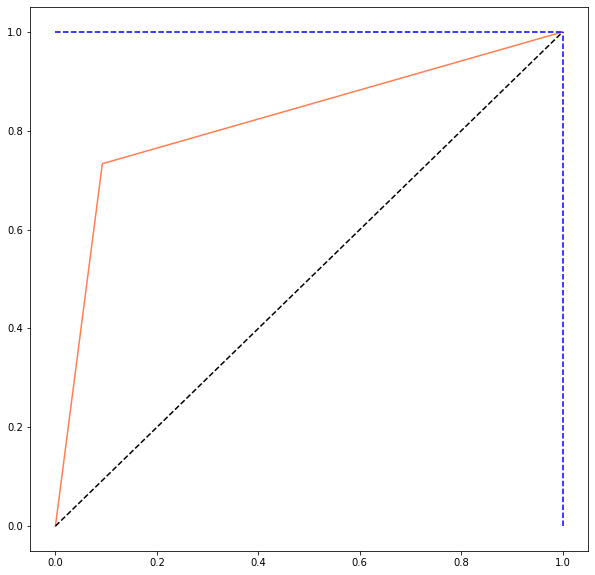

In [1054]:
plt.figure()
plt.plot(fpr, tpr, color = 'coral', label = 'The ROC  curve:' + str(auc(fpr, tpr)))
plt.plot([0, 1], [0,1], 'k--')
plt.plot([0, fpr[idx]], [tpr[idx], tpr[idx]], 'k--', color = 'blue')
plt.plot([tpr[idx], tpr[idx]], [0, fpr[idx]], 'k--', color = 'blue')

In [1061]:
# plotting the confusion matrix

confusion_matrix(y_test, y_predict)

array([[69, 50],
       [41, 19]])